In [66]:
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# ====== INPUT / OUTPUT ======
INPUT_IMAGE = Path("dataset/writer1/J/S__10805260.jpg")   # <-- เปลี่ยนเป็น path รูปแถวของคุณ
WRITER_NAME = "writer1"                 # writer1 หรือ writer2
LETTER_LABEL = "J"                      # ภาพนี้เป็นตัวอะไร (A,B,C,...)
OUT_ROOT = Path("dataset")              # root dataset folder
OUT_DIR = OUT_ROOT / WRITER_NAME / LETTER_LABEL
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ====== SEGMENTATION PARAMS (ปรับได้) ======
MIN_AREA = 150          # กรอง noise เล็กๆ (ปรับตามภาพ)
MIN_H = 20              # ความสูงขั้นต่ำของตัวอักษร
MIN_W = 10              # ความกว้างขั้นต่ำของตัวอักษร
MAX_ASPECT = 2.0        # กว้าง/สูง มากไปมักไม่ใช่ตัวอักษร
MORPH_KERNEL = 3        # kernel size สำหรับ morphology

print("Saving to:", OUT_DIR.resolve())


Saving to: /Users/sarawit/Documents/Year2/sem2/Computer_vision/cv_preocr/dataset/writer1/J


In [67]:
def show(img, title="", cmap=None, size=(12,3)):
    plt.figure(figsize=size)
    if img.ndim == 2:
        plt.imshow(img, cmap=cmap if cmap else "gray")
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()


In [68]:
def preprocess_for_segmentation(img_bgr):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (3,3), 0)

    # binary + invert: ink becomes white
    _, bw = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # remove small noise
    k = np.ones((MORPH_KERNEL, MORPH_KERNEL), np.uint8)
    bw = cv2.morphologyEx(bw, cv2.MORPH_OPEN, k, iterations=1)

    # connect small gaps (optional, helps broken strokes)
    bw = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, k, iterations=1)
    return bw


In [69]:
def find_char_boxes(bw):
    """
    Return list of boxes (x,y,w,h) sorted left-to-right
    """
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(bw, connectivity=8)
    boxes = []
    for i in range(1, num_labels):  # skip background
        x, y, w, h, area = stats[i]
        if area < MIN_AREA:
            continue
        if w < MIN_W or h < MIN_H:
            continue
        aspect = w / float(h)
        if aspect > MAX_ASPECT:
            continue
        boxes.append((x, y, w, h, area))

    # sort left-to-right by x
    boxes.sort(key=lambda b: b[0])
    return boxes


Detected boxes: 17


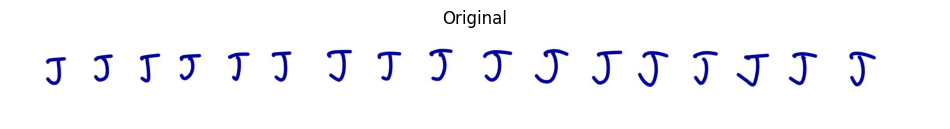

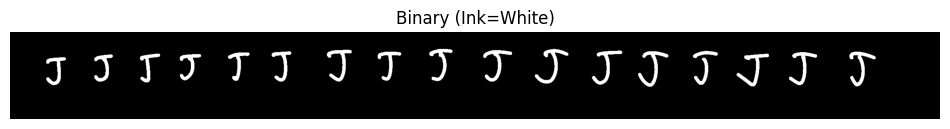

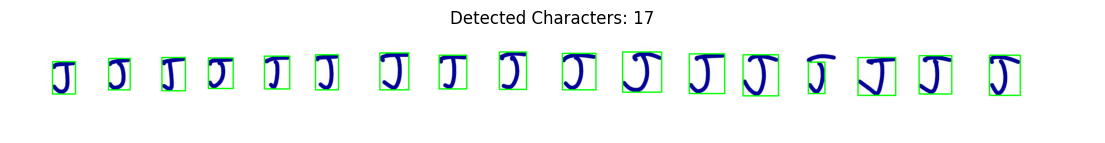

In [70]:
img = cv2.imread(str(INPUT_IMAGE))
if img is None:
    raise FileNotFoundError(f"Cannot read image: {INPUT_IMAGE.resolve()}")

bw = preprocess_for_segmentation(img)
boxes = find_char_boxes(bw)

print("Detected boxes:", len(boxes))

# draw boxes
vis = img.copy()
for (x,y,w,h,area) in boxes:
    cv2.rectangle(vis, (x,y), (x+w, y+h), (0,255,0), 2)

show(img, "Original")
show(bw, "Binary (Ink=White)")
show(vis, f"Detected Characters: {len(boxes)}", size=(14,3))


In [71]:
def crop_with_padding(bw, x, y, w, h, pad=5):
    H, W = bw.shape
    x0 = max(x - pad, 0)
    y0 = max(y - pad, 0)
    x1 = min(x + w + pad, W)
    y1 = min(y + h + pad, H)
    return bw[y0:y1, x0:x1]

saved_paths = []
for idx, (x,y,w,h,area) in enumerate(boxes, start=1):
    crop = crop_with_padding(bw, x, y, w, h, pad=6)
    
    # OPTIONAL: make background black, ink white (already)
    out_name = f"{LETTER_LABEL}_{idx:03d}.png"
    out_path = OUT_DIR / out_name
    cv2.imwrite(str(out_path), crop)
    saved_paths.append(out_path)

print("Saved crops:", len(saved_paths))
print("Example:", saved_paths[:3])


Saved crops: 17
Example: [PosixPath('dataset/writer1/J/J_001.png'), PosixPath('dataset/writer1/J/J_002.png'), PosixPath('dataset/writer1/J/J_003.png')]


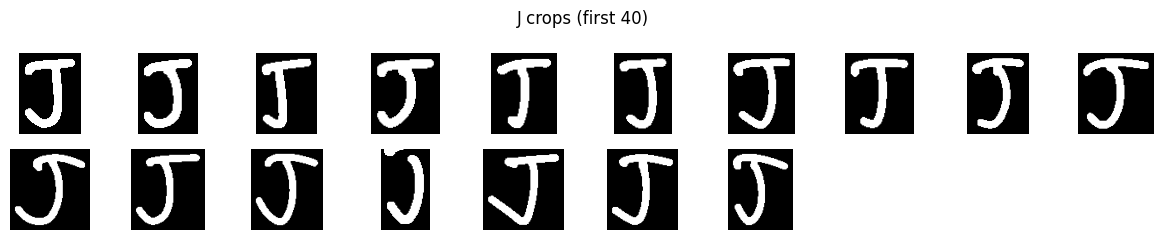

In [72]:
def show_grid(img_paths, cols=10, title="Crops"):
    imgs = []
    for p in img_paths:
        im = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
        if im is not None:
            imgs.append(im)

    if len(imgs) == 0:
        print("No crops to show.")
        return

    rows = int(np.ceil(len(imgs) / cols))
    plt.figure(figsize=(cols*1.2, rows*1.2))
    for i, im in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.imshow(im, cmap="gray")
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_grid(saved_paths[:40], cols=10, title=f"{LETTER_LABEL} crops (first 40)")
